# In this notebook, we are going to implement Efficient model to analysis the data
# Applied oversampling for the imbalance data.
## https://arxiv.org/abs/1409.1556


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


# Read metadata.csv

In [2]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

# Preprocess labels

In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age      sex  \
7574  HAM_0007483  ISIC_0032628   nv      histo  35.0   female   
1833  HAM_0006923  ISIC_0032656  mel      histo  80.0     male   
263   HAM_0001837  ISIC_0033868  bkl      histo  80.0     male   
3113  HAM_0000526  ISIC_0029997   nv  follow_up   5.0     male   
969   HAM_0002660  ISIC_0033750  bkl  consensus   NaN  unknown   

         localization  label  
7574             back      5  
1833             foot      4  
263             trunk      2  
3113  upper extremity      5  
969           unknown      2  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

# Preprocess Pmage

In [5]:
from glob import glob
image_size = 80 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [6]:
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

# Print some image

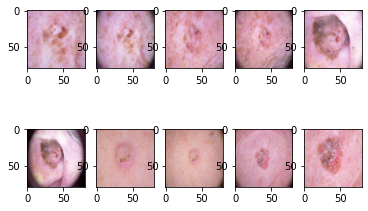

In [7]:
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

# Image to Array

In [8]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list()).astype("short")
label_to_one_hot = to_categorical(df['label'], num_classes=7)

# Split train and test data

In [9]:
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=87,stratify=label_to_one_hot)

# Applying over sampling

In [10]:
from imblearn.over_sampling import SMOTE
over_sample = SMOTE(random_state=87)
train_data = train_data.reshape(-1,image_size*image_size*3)
train_data_oversample, train_label_oversample = over_sample.fit_resample(train_data, train_label)
train_data_oversample = train_data_oversample.reshape(-1,image_size,image_size,3)

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [11]:
# the sample size is super big so we need to deal with it separately
train_data_oversample = train_data_oversample/255
test_data = test_data/255

# Setup Efficient Net model

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten
import efficientnet.tfkeras as ef
num_classes = 7
dimension = image_size*image_size*3

EN_model = ef.EfficientNetB0(input_shape=(image_size,image_size,3), include_top = False, weights='imagenet')

for layer in EN_model.layers:
    layer.trainable = False

#Flatten layer
temp_layer = Flatten()(EN_model.output)

#Dense layer 1
temp_layer = Dense(1024,activation='relu')(temp_layer)
temp_layer = Dropout(0.5)(temp_layer)

#output layer
temp_layer = Dense(7,activation='softmax')(temp_layer)

model = Model(EN_model.input,temp_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 40, 40, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 40, 40, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 40, 40, 32)   0           stem_bn[0][0]                    
______________________________________________________________________________________________

# Use Adam optimizer

In [13]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Checkpoint: save the best score
# EarlyStopping: stop early if there is no change in "val_acc" after 50 runs

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
check_point = ModelCheckpoint("model/Efficient_Net.h5", monitor='val_acc', verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=50, verbose=1, mode='auto')

# Train

In [ ]:
try:
    model.load_weights('model/Efficient_Net_weights.h5')
except:
    print("new model")
epochs = 1000

train_history = model.fit(
    train_data_oversample,train_label_oversample,
    epochs=epochs,
    steps_per_epoch=200,
    validation_split=0.3,
    verbose=2,shuffle=True,callbacks=check_point)

model.save_weights('model/Efficient_Net_weights.h5')

new model
Epoch 1/1000
200/200 - 32s - loss: 0.2583 - acc: 0.9074 - val_loss: 1.5130 - val_acc: 0.5976

Epoch 00001: val_acc did not improve from 0.61403
Epoch 2/1000
200/200 - 36s - loss: 0.2738 - acc: 0.9004 - val_loss: 1.3001 - val_acc: 0.6386

Epoch 00002: val_acc improved from 0.61403 to 0.63862, saving model to model\Efficient_Net.h5


C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/1000
200/200 - 36s - loss: 0.2519 - acc: 0.9093 - val_loss: 1.5751 - val_acc: 0.6273

Epoch 00003: val_acc did not improve from 0.63862
Epoch 4/1000
200/200 - 33s - loss: 0.2579 - acc: 0.9063 - val_loss: 1.3039 - val_acc: 0.6214

Epoch 00004: val_acc did not improve from 0.63862
Epoch 5/1000
200/200 - 35s - loss: 0.2530 - acc: 0.9057 - val_loss: 1.4989 - val_acc: 0.6070

Epoch 00005: val_acc did not improve from 0.63862
Epoch 6/1000
200/200 - 35s - loss: 0.2574 - acc: 0.9077 - val_loss: 1.2565 - val_acc: 0.6471

Epoch 00006: val_acc improved from 0.63862 to 0.64714, saving model to model\Efficient_Net.h5
Epoch 7/1000
200/200 - 35s - loss: 0.2423 - acc: 0.9107 - val_loss: 1.6220 - val_acc: 0.5863

Epoch 00007: val_acc did not improve from 0.64714
Epoch 8/1000
200/200 - 33s - loss: 0.2433 - acc: 0.9124 - val_loss: 1.6108 - val_acc: 0.5805

Epoch 00008: val_acc did not improve from 0.64714
Epoch 9/1000
200/200 - 35s - loss: 0.2447 - acc: 0.9123 - val_loss: 1.5014 - val_acc: 0.5907

In [16]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

# Train history

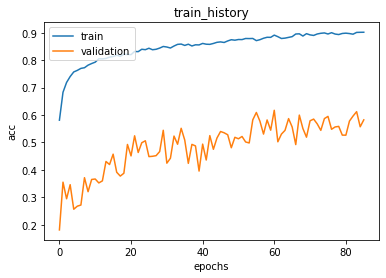

In [17]:
plot_train_history(train_history,'acc','val_acc')

# Loss

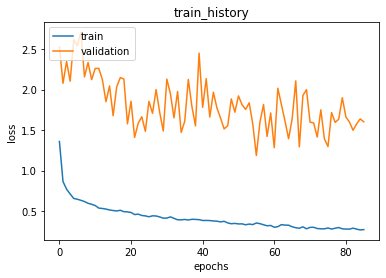

In [18]:
plot_train_history(train_history,'loss','val_loss')

# Score

In [19]:
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

63/63 [==============================] - 2s 22ms/step - loss: 1.2102 - acc: 0.7284

# confusion matrix

In [20]:
prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
prediction_label = np.argmax(test_label,axis=1)

mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])

print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))


predicted  akiex  bcc  bkl  df  mel    nv  vasc
actual                                         
akiex         33   12   10   1    3     6     0
bcc           10   67   10   1    5    10     0
bkl           30   15  104   0   25    46     0
df             4    3    1   7    0     8     0
mel           21    9   37   1   68    87     0
nv            13   21  103   2   33  1168     1
vasc           1    4    2   0    1     8    12
